In [1]:
# coding=utf-8
import copy
import math
import time

import numpy as np
import seaborn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
seaborn.set_context(context='talk')
%matplotlib inline

In [3]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_ebed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_ebed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        'take in and process masked src and tgt sequence'
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    def encode(self, src, src_mask):
        return Variable(self.encoder(self.src_embed(src), src_mask))

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return Variable(self.decoder(self.tgt_embed(tgt),memory,src_mask,tgt_mask))

In [4]:
class Generator(nn.Module):
    'define standard linear + softmax generation step'
    'map the matrix to a vector that represents the probability, so the output dimension is the size of vocab'

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [5]:
def clones(module, N):
    'produce N identical layers'
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


In [39]:
class Encoder(nn.Module):
    'core encoder is a stack of N layers'

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        'pass the input and mask through each layer in turn'
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [7]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.ones(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return (self.a_2 * (x - mean) / (std + self.eps) + self.b_2)


In [37]:
class SublayerConnection(nn.Module):
    'a residual connection followed by a layer norm.'
    'note for code simplicity the norm is first as opposed to last'

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        'apply residual connection to any sublayer with the same size'
        return x + self.dropout(sublayer(self.norm(x)))

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        'follow figure 1 for connection'
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [10]:
class Decoder(nn.Module):
    'generic N layer decoder with masking'

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


In [11]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        'follow figure 1 for connection'
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)


In [12]:
def subsequent_mask(size):
    'mask out subsequent positions.'
    attn_shape = (1, size, size)
    # np.triu 返回上三角矩阵 就是把之后位置的数据mask掉
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [13]:
def attention(query, key, value, mask=None, dropout=None):
    'compute scaled dot product attention'
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        # masked_fill_(mask, value): 在mask值为1的位置处用value填充。mask的元素个数需和本tensor相同，但尺寸可以不同。
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        'implement figure 2'
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        'do all the linear projections in batch from d_model-> h * d_k'
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in
                             zip(self.linears, (query, key, value))
                             ]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [15]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [16]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)


In [17]:
class PositionalEncoding(nn.Module):
    'implement the PE function'

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        'compute the positional encodings once in log space'
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

In [18]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
                           Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
                           nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
                           nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
                           Generator(d_model, tgt_vocab))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return model

In [19]:
tmp_model = make_model(10, 10, 2)

In [20]:
class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))

        return tgt_mask

In [21]:
def run_epoch(data_iter, model, loss_compute,epoch=0):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss.detach().cpu().numpy()
        total_tokens += batch.ntokens.cpu().numpy()
        tokens += batch.ntokens.cpu().numpy()
        if i % 50 == 1:
            elapsed = time.time() - start
            print('epoch step: %d loss: %f tokens per sec: %f' % (i, loss.detach().cpu().numpy() / batch.ntokens.cpu().numpy(), tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [22]:
global max_src_in_batch, max_tgt_in_batch

In [23]:
def batch_size_fn(new, count, sofar):
    'keep augmenting batch and calculate total number of tokens + padding.'
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [24]:
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        'update parameters and rate'
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        'implement `lrate` above'
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))

In [25]:
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
                   torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

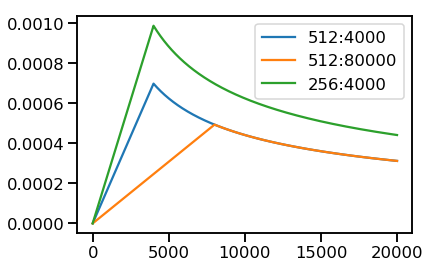

In [26]:
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:80000", "256:4000"])

In [27]:
class LabelSmoothing(nn.Module):
    'implement label smoothing'

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=True))

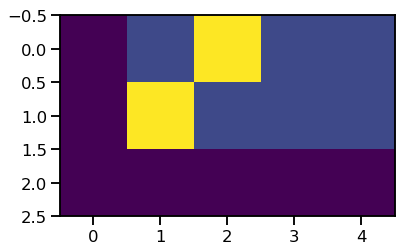

In [28]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])

v=crit(Variable(predict.log()),Variable(torch.LongTensor([2,1,0])))
plt.imshow(crit.true_dist)

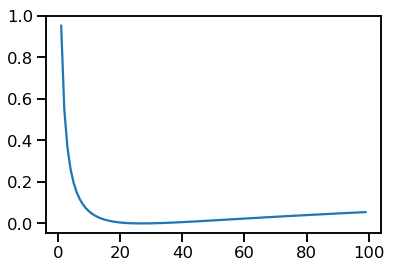

In [29]:
crit = LabelSmoothing(5,0,0.1)
def loss(x):
    d=x+3*1
    predict=torch.FloatTensor([[0,x/d,1/d,1/d,1/d],])
    
    #print(predict)
    
    return crit(Variable(predict.log()),Variable(torch.LongTensor([1]))).item()
plt.plot(np.arange(1,100),[loss(x) for x in range(1,100)])


In [35]:
def data_gen(V,batch,nbatches):
    'generate random data for a src_tgt copy task'
    for i in  range(nbatches):
        data=torch.from_numpy(np.random.randint(1,V,size=(batch,10)))
        data[:,0]=1
        src=Variable(data,requires_grad=False).long()
        tgt=Variable(data,requires_grad=False).long()
        yield Batch(src,tgt,0)

In [31]:
class SimpleLossCompute:
    'a simple loss compute and train function'
    def __init__(self,generator,criterion,opt=None):
        self.generator=generator
        self.criterion=criterion
        self.opt=opt
    
    def __call__(self,x,y,norm):
        x=self.generator(x)
        loss=self.criterion(x.contiguous().view(-1,x.size(-1)),y.contiguous().view(-1))/norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item()*norm.float()

In [40]:
V=11
criterion=LabelSmoothing(size=V,padding_idx=0,smoothing=0.0)
model=make_model(V,V,N=2)
model_opt=NoamOpt(model.src_embed[0].d_model,1,400,torch.optim.Adam(model.parameters(),lr=0,betas=(0.9,0.98),eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V,30,20),model,SimpleLossCompute(model.generator,criterion,model_opt))
    model.eval()
    print(run_epoch(data_gen(V,30,5),model,SimpleLossCompute(model.generator,criterion,None)))
                

epoch step: 1 loss: 3.327344 tokens per sec: 1253.343279
epoch step: 1 loss: 2.724987 tokens per sec: 1330.329269
2.7759569408275464
epoch step: 1 loss: 2.898595 tokens per sec: 1227.764873
epoch step: 1 loss: 2.426158 tokens per sec: 1343.537936
2.4835723198784723
epoch step: 1 loss: 2.571107 tokens per sec: 1184.778337
epoch step: 1 loss: 2.417124 tokens per sec: 1012.831942
2.4164194064670137
epoch step: 1 loss: 2.575187 tokens per sec: 1118.686574
epoch step: 1 loss: 2.354941 tokens per sec: 1292.231665
2.3720524540653933
epoch step: 1 loss: 2.487728 tokens per sec: 1179.615438
epoch step: 1 loss: 2.324143 tokens per sec: 1310.997677
2.337884521484375
epoch step: 1 loss: 2.505251 tokens per sec: 1182.192793
epoch step: 1 loss: 2.319235 tokens per sec: 1327.069527
2.307519033926505
epoch step: 1 loss: 2.492591 tokens per sec: 1227.768866
epoch step: 1 loss: 2.260157 tokens per sec: 1074.288804
2.249989284939236
epoch step: 1 loss: 2.370180 tokens per sec: 1182.194027
epoch step: 1 l

In [ ]:
# this code predicts a translation using greedy decoder for simplicity.
